In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import opening, disk
from skimage.transform import resize
sns.set()
from tqdm import tqdm
plt.rcParams["axes.grid"] = False

In [4]:
filename = "../../data/Galaxy10_DECals.h5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    ds_obj = f[a_group_key]  
    ds_arr = f[a_group_key][()]
    ra = f['ra'][()]
    dec = f['dec'][()]
    z = f['redshift'][()]
    label = f['labels'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['dec', 'images', 'labels', 'ra', 'redshift']>


In [5]:
print(images.shape)

(17736, 256, 256, 3)


/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_11861/57416499.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


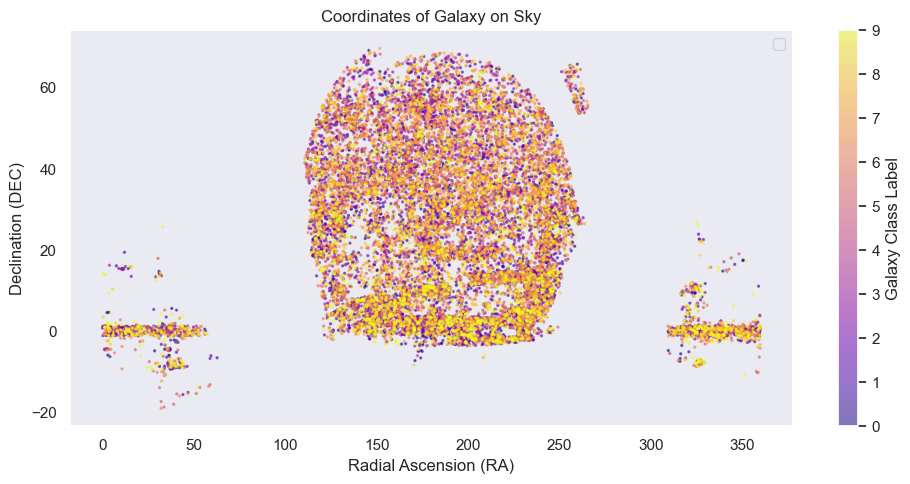

In [6]:
plt.figure(figsize = (10,5))
plt.scatter(ra, dec, c = label, s = 2, cmap = 'plasma', alpha = .5)
cb = plt.colorbar() 
cb.set_label('Galaxy Class Label') 
plt.title("Coordinates of Galaxy on Sky")
plt.xlabel("Radial Ascension (RA)")
plt.ylabel("Declination (DEC)")
plt.legend()
plt.tight_layout()

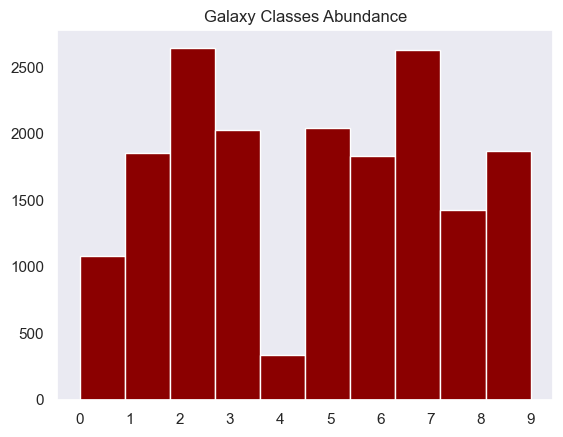

In [7]:
plt.hist(label, color = 'darkred')
plt.title('Galaxy Classes Abundance')
plt.xticks(np.arange(0, 10, 1));

In [8]:
def add_poisson_noise(image: np.array, snr: float):
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image)
    noise_level = signal_level / snr  - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    
    return noisy_image

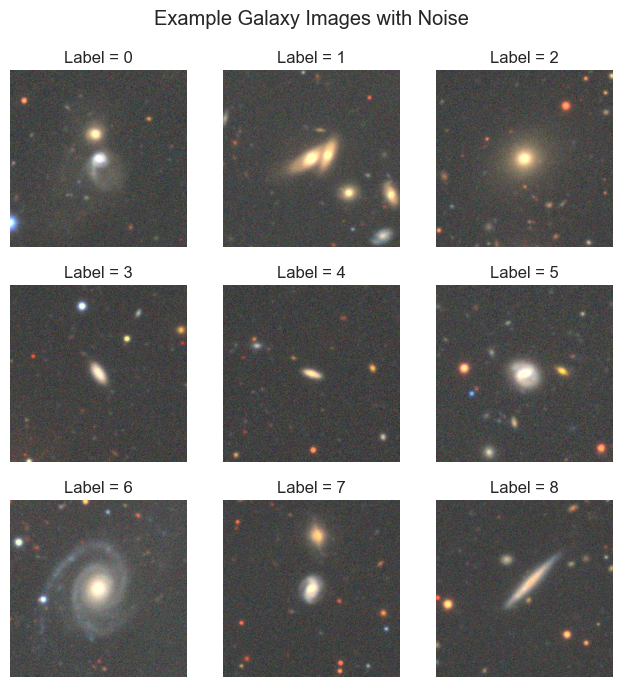

In [9]:
fig = plt.figure(figsize=(7,7))
for i in range(3*3):
    fig.suptitle('Example Galaxy Images with Noise')
    ax = fig.add_subplot(3,3, i+1)
    ax.axis('off')
    idx = np.where(label == i)[0][1]
    plt.imshow(add_poisson_noise(images[idx], 0.50))
    plt.grid(None)
    plt.tight_layout()
    plt.title(f'Label = {label[idx]}')


In [11]:
def save_in_h5py(f, images, labels):
    dataset = f.create_dataset(
        "images", np.shape(images), data=images, compression='gzip', chunks=True)
    meta_set = f.create_dataset(
        "labels", np.shape(labels), data=labels,  compression='gzip', chunks=True)

In [ ]:
noisy_images = []
NOISE_LEVEL = 0.5
for image in tqdm(images):
    noisy_image = add_poisson_noise(image, NOISE_LEVEL)
    noisy_images.append(noisy_image)

In [ ]:
noisy_images = np.asarray(noisy_images)
f = h5py.File('../../data/Galaxy10_DECals_noise.h5','w')
save_in_h5py(f, noisy_images, label)
f.close()